In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils import resample
import math as math
from itertools import chain

In [5]:
Data = pd.read_csv('House_Price_Regression.csv')

In [6]:
Data_quant = Data.loc[:, ['latitude', 'longitude', 'price', 'size_in_m_2', 'no_of_bedrooms', 'no_of_bathrooms']]

Data_quant.head()

,latitude,longitude,price,size_in_m_2,no_of_bedrooms,no_of_bathrooms
0,25.113208,55.138932,2700000,100.242337,1,2
1,25.106809,55.151201,2850000,146.972546,2,2
2,25.063302,55.137728,1150000,181.253753,3,5
3,25.227295,55.341761,2850000,187.664060,2,3
4,25.114275,55.139764,1729200,47.101821,0,1


## Distancias (funciones)

In [231]:
def Dist_Euclidea(x_i, x_r):

        Dist_Euclidea = ( ( x_i - x_r )**2 ).sum()

        Dist_Euclidea = np.sqrt(Dist_Euclidea)

        return Dist_Euclidea

In [232]:
def Matrix_Dist_Euclidea(Data):

    if isinstance(Data, pd.DataFrame):
        Data = Data.to_numpy()
    elif isinstance(Data, np.ndarray):
        pass

    n = len(Data)

    M =  np.empty((n , n))

    
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Euclidea(Data[i,:] , Data[r,:])   

                      
    return M 

In [9]:
def Dist_Minkowski(x_i, x_r, q):

    Dist_Minkowski = ( ( ( abs( x_i - x_r) )**q ).sum() )**(1/q)

    return Dist_Minkowski

In [10]:
def Matrix_Dist_Minkowski(Data, q):

    if isinstance(Data, pd.DataFrame):
        Data = Data.to_numpy()
    elif isinstance(Data, np.ndarray):
        pass

    n = len(Data)

    M =  np.empty((n , n))

    
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Minkowski(Data[i,:] , Data[r,:], q)   
                      
    return M 

In [11]:
def Dist_Canberra(x_i, x_r):

    numerator =  abs( x_i - x_r )

    denominator =  ( abs(x_i) + abs(x_r) )
       
    numerator=np.array([numerator], dtype=float)

    denominator=np.array([denominator], dtype=float)

    # The following code is to eliminate zero division problems

    Dist_Canberra = ( np.divide( numerator , denominator , out=np.zeros_like(numerator), where=denominator!=0) ).sum() 

    return Dist_Canberra

In [12]:
def Matrix_Dist_Canberra(Data):

    if isinstance(Data, pd.DataFrame):
        Data = Data.to_numpy()
    elif isinstance(Data, np.ndarray):
        pass

    n = len(Data)

    M =  np.empty((n , n))

    
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Canberra(Data[i,:] , Data[r,:])   
                     
    return M 

In [13]:
def Dist_Pearson(x_i, x_r, variance) :

    Dist_Pearson = ( ( x_i - x_r )**2 / variance ).sum()

    Dist_Pearson = np.sqrt(Dist_Pearson)

    return Dist_Pearson

In [14]:
def Matrix_Dist_Pearson(Data):

    if isinstance(Data, pd.DataFrame):
        Data = Data.to_numpy()
    elif isinstance(Data, np.ndarray):
        pass

    n = len(Data)

    M =  np.empty((n , n))

    
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Pearson(Data[i,:] , Data[r,:], variance=np.var(Data, axis=0, ddof=1))   
                     
    return M 

In [15]:
def Dist_Mahalanobis(x, S_inv):  # Más eficiente que la anterior

    # All the columns of Data must be type = 'float' or 'int' (specially not 'object'), in other case we will find 
    # dimensional problems when Python compute   x @ S_inv @ x.T

    # x = (x_i - x_r)

    # x = np.array([x]) # necessary step to transpose a 1D array

    Dist_Maha = np.sqrt( x @ S_inv @ x.T )  # x @ S_inv @ x.T = np.matmul( np.matmul(x , S_inv) , x.T )

    Dist_Maha = float(Dist_Maha)

    return Dist_Maha

In [16]:
def Matrix_Dist_Mahalanobis(Data):

    if isinstance(Data, pd.DataFrame):
        Data = Data.to_numpy()
    elif isinstance(Data, np.ndarray):
        pass

    n = len(Data)

    M =  np.empty((n , n))

    S_inv=np.linalg.inv( np.cov(Data , rowvar=False) )

   
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Mahalanobis(x = np.array([Data[i,:] - Data[r,:]]) , S_inv=S_inv ) 

                      
    return M 

## Algoritmo k-medias

In [20]:
def k_means(k, Data, d, random_seed=123, n_iter=50, q=1, var=None, S_inv=None):

    # Data --> a numpy array
    # d --> name of distance (Euclidea, Minkowski, Canberra, Pearson or Mahalanobis)
    # q --> parametro necesario si se usa la distancia Minkowski
    # S_inv --> parametro necesario si se usa la distancia Mahalanobis
    # random_seed --> semilla aleatoria
    # k --> nº clusters
    # n_iter --> nº maximo de iteraciones del algoritmo

###########################################################################################

    df_clusters_iter_list = []

    if isinstance(Data, pd.DataFrame):
        Data = Data.to_numpy()
    elif isinstance(Data, np.ndarray):
        pass

###########################################################################################

    # Distance definition:

    Dist_d = globals()["Dist_" + d]


    def Distance(x_i, x_r, d, q, var, S_inv):
        
        if d == "Euclidea":
    
            distance = Dist_d(x_i , x_r)

        elif d == "Canberra":
            
            distance = Dist_d(x_i , x_r)

        elif d == "Minkowski":
             
            distance = Dist_d(x_i , x_r, q)

        elif d == "Pearson":
    
            distance = Dist_d(x_i , x_r, variance=var)

        elif d == "Mahalanobis":
         
            distance = Dist_d(x_i-x_r, S_inv)

        return distance

###########################################################################################

    # Random generation of the initial clusters:

    sample = resample(range(0, len(Data)), n_samples=len(Data), replace=False, random_state=random_seed)

    df_sample = pd.DataFrame({'index': range(0,len(Data)) , 'sample':sample})

    Q = []

    for q in np.arange(0 , 1 + 1/k , 1/k):

        Q.append( np.quantile( range(0, len(Data)) , q ).round(0) )

    labels_clusters = np.array([0])

    for j in range(0,k):
   
        labels_clusters = np.concatenate([labels_clusters, np.repeat( j, len( df_sample.loc[Q[j]:(math.floor(Q[j+1])-1), 'sample'] ) ) ] ) 

    df_cluster = pd.DataFrame({'observation': df_sample['sample'] , 'cluster': labels_clusters})

    df_clusters_iter_list.append(df_cluster)

###########################################################################################

    # Computing the centroids of the initial clusters:

    Centroids = [ ]

    for j in range(0, k):

      observations_index_cluster_j = df_cluster.loc[df_cluster.cluster == j, :].observation

      Data_cluster_j = Data[observations_index_cluster_j , :]

      Centroid_cluster_j =  Data_cluster_j.mean(axis=0)

      Centroids.append( Centroid_cluster_j  ) 

###########################################################################################

   # Computing the sum of intra-clusters variances for the initial cluster:

    distances = [ ]

    intra_cluster_variance_list , sum_intra_clusters_variances, sum_intra_clusters_variances_list = [ ], [ ], [ ]

    for j in range(0,k):

        observations_index_cluster_j = df_cluster.loc[df_cluster.cluster == j, :].observation 

        for i in observations_index_cluster_j :

            distances.append(Distance(x_i=Data[i,:], x_r=Centroids[j], d=d, q=q, var=var, S_inv=S_inv))

        # distances = Parallel(n_jobs=-1)(delayed(Distance)(x_i=Data[i,:], x_r=Centroids[j], d=d, q=q, var=var, S_inv=S_inv) for i in observations_index_cluster_j)          

        square_distances = [x**2 for x in distances]
        intra_cluster_variance = sum(square_distances)
        intra_cluster_variance_list.append( intra_cluster_variance )

    sum_intra_clusters_variances.append( sum(intra_cluster_variance_list) )
    sum_intra_clusters_variances_list.append( sum_intra_clusters_variances )


###########################################################################################

    # Computing the new clusters configuration for each iteration:

    for b in range(0 , n_iter):
       
       # Assign each observation to their nearest cluster: 

        labels_clusters = []

        for i in df_sample['sample']:

            distances = []
    
            for j in range(0,k):

                distances.append( Distance(x_i=Data[i,:], x_r=Centroids[j], d=d, q=q, var=var, S_inv=S_inv) )  

            df_distances_x_i_clusters = pd.DataFrame({'Distances' : distances , 'Cluster': range(0,k)})

            df_distances_x_i_clusters_sort = df_distances_x_i_clusters.sort_values(by='Distances', ascending=True)

            labels_clusters.append( df_distances_x_i_clusters_sort.iloc[0]['Cluster'] )
        
        df_cluster = pd.DataFrame({'observation' : df_sample['sample'] , 'cluster': labels_clusters})

###########################################################################################

       # Computing the centroids of the new clusters:

        Centroids = []

        for j in range(0, k):                    
                
            observations_index_cluster_j = df_cluster.loc[df_cluster.cluster == j, :].observation

            Data_cluster_j = Data[observations_index_cluster_j , :]

            Centroid_cluster_j =  Data_cluster_j.mean(axis=0)

            Centroids.append( Centroid_cluster_j ) 
      
###########################################################################################

        # Computing the sum of intra-clusters variances for the new clusters:
        
        distances = []
        intra_cluster_variance_list , sum_intra_clusters_variances = [ ], [ ]

        for j in range(0,k):

            observations_index_cluster_j = df_cluster.loc[df_cluster.cluster == j, :].observation 

            for i in observations_index_cluster_j :

                distances.append( Distance(x_i=Data[i,:], x_r=Centroids[j], d=d, q=q, var=var, S_inv=S_inv) )

            # distances = Parallel(n_jobs=-1)(delayed(Distance)(x_i=Data[i,:], x_r=Centroids[j], d=d, q=q, var=var, S_inv=S_inv) for i in observations_index_cluster_j)          

            square_distances = [x**2 for x in distances]
            intra_cluster_variance = sum(square_distances)
            intra_cluster_variance_list.append( intra_cluster_variance )

        sum_intra_clusters_variances.append( sum(intra_cluster_variance_list) )
        sum_intra_clusters_variances_list.append( sum_intra_clusters_variances )

######################################################################################

        df_clusters_iter = pd.DataFrame({'observations': df_sample['sample']  , 'cluster': labels_clusters })

        df_clusters_iter_list.append(df_clusters_iter)

######################################################################################
######################################################################################
    
    # unlist a list:

    sum_intra_clusters_variances_list = list(chain.from_iterable(sum_intra_clusters_variances_list))

######################################################################################
    df_sum_intra_clusters_variances = pd.DataFrame({'sum_intra_cluster_var':sum_intra_clusters_variances_list  , 'iter': range(0, n_iter+1)})
    
    sort_df_sum_intra_clusters_variances = df_sum_intra_clusters_variances.sort_values(by='sum_intra_cluster_var', ascending=True)

    optimal_iter = sort_df_sum_intra_clusters_variances.iloc[0,1]

    df_optimal_clusters = df_clusters_iter_list[optimal_iter]
######################################################################################

    return df_optimal_clusters, df_clusters_iter_list, sort_df_sum_intra_clusters_variances,  df_sum_intra_clusters_variances


### Prueba con la distancia Euclidea

In [23]:
df_optimal_clusters, df_clusters_iter_list, sort_df_sum_intra_clusters_variances, df_sum_intra_clusters_variances = k_means(k=4, Data=Data_quant, d='Euclidea', random_seed=123, n_iter=15)

In [ ]:
# 1.18 mins (sin parallel Joblib, k=4, n_iter=50, dist euclidea)
# 2.8 min (con parallel joblib k=4, n_iter=50, dist euclidea)

In [132]:
df_optimal_clusters

,observations,cluster
0,382,0.0
1,732,2.0
2,1888,1.0
3,679,1.0
4,1004,2.0
...,...,...
1900,1122,1.0
1901,1346,1.0
1902,1406,1.0
1903,1389,2.0


In [133]:
df_clusters_iter_list[0:4]

[      observations  cluster
 0              382      0.0
 1              732      1.0
 2             1888      1.0
 3              679      1.0
 4             1004      0.0
 ...            ...      ...
 1900          1122      1.0
 1901          1346      1.0
 1902          1406      1.0
 1903          1389      1.0
 1904          1534      0.0
 
 [1905 rows x 2 columns],
       observations  cluster
 0              382      0.0
 1              732      2.0
 2             1888      1.0
 3              679      1.0
 4             1004      3.0
 ...            ...      ...
 1900          1122      1.0
 1901          1346      1.0
 1902          1406      1.0
 1903          1389      2.0
 1904          1534      0.0
 
 [1905 rows x 2 columns],
       observations  cluster
 0              382      0.0
 1              732      2.0
 2             1888      1.0
 3              679      1.0
 4             1004      3.0
 ...            ...      ...
 1900          1122      1.0
 1901          1

In [134]:
df_sum_intra_clusters_variances.head(5)

,sum_intra_cluster_var,iter
0,4.069688e+16,0
1,4.570241e+16,1
2,3.344560e+16,2
3,1.963613e+16,3
4,1.131529e+16,4


In [135]:
sort_df_sum_intra_clusters_variances.head(5)

,sum_intra_cluster_var,iter
9,6.807861e+15,9
10,6.829961e+15,10
11,6.849922e+15,11
12,6.866743e+15,12
13,6.892440e+15,13


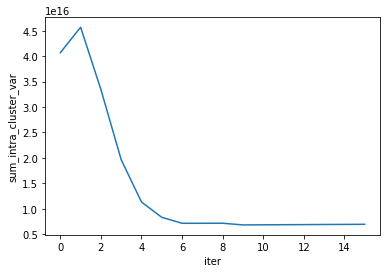

In [136]:
plot = sns.lineplot(data=df_sum_intra_clusters_variances, y='sum_intra_cluster_var', x='iter')

In [220]:
from sklearn.metrics import silhouette_score

silhouette_score(Data_quant, df_optimal_clusters.sort_values(by='observations').cluster, metric='euclidean')

0.5548752565475771

In [221]:
D_euclidean = Matrix_Dist_Euclidea(Data=Data_quant)

D_euclidean = D_euclidean + D_euclidean.T

df_silhouette , mean_silhouette = silhouette(Distance_Matrix=D_euclidean, k=4, df_clusters=df_optimal_clusters)

mean_silhouette

0.5555770916912831

### Prueba distancia Minkowski

In [215]:
df_optimal_clusters, df_clusters_iter_list, sort_df_sum_intra_clusters_variances, df_sum_intra_clusters_variances = k_means(k=4, Data=Data_quant, d='Minkowski', q=1, random_seed=123, n_iter=15)

In [138]:
df_optimal_clusters

,observations,cluster
0,382,0.0
1,732,2.0
2,1888,1.0
3,679,1.0
4,1004,2.0
...,...,...
1900,1122,1.0
1901,1346,1.0
1902,1406,1.0
1903,1389,2.0


In [139]:
df_clusters_iter_list[0:4]

[      observations  cluster
 0              382      0.0
 1              732      1.0
 2             1888      1.0
 3              679      1.0
 4             1004      0.0
 ...            ...      ...
 1900          1122      1.0
 1901          1346      1.0
 1902          1406      1.0
 1903          1389      1.0
 1904          1534      0.0
 
 [1905 rows x 2 columns],
       observations  cluster
 0              382      0.0
 1              732      2.0
 2             1888      1.0
 3              679      1.0
 4             1004      3.0
 ...            ...      ...
 1900          1122      1.0
 1901          1346      1.0
 1902          1406      1.0
 1903          1389      2.0
 1904          1534      0.0
 
 [1905 rows x 2 columns],
       observations  cluster
 0              382      0.0
 1              732      2.0
 2             1888      1.0
 3              679      1.0
 4             1004      3.0
 ...            ...      ...
 1900          1122      1.0
 1901          1

In [140]:
df_sum_intra_clusters_variances.head(5)

,sum_intra_cluster_var,iter
0,4.069883e+16,0
1,4.570436e+16,1
2,3.344699e+16,2
3,1.963695e+16,3
4,1.131581e+16,4


In [141]:
sort_df_sum_intra_clusters_variances.head(5)

,sum_intra_cluster_var,iter
9,6.808237e+15,9
10,6.830343e+15,10
11,6.850305e+15,11
12,6.867131e+15,12
13,6.892832e+15,13


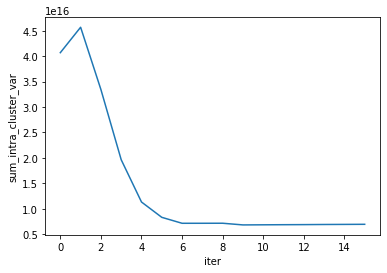

In [142]:
plot = sns.lineplot(data=df_sum_intra_clusters_variances, y='sum_intra_cluster_var', x='iter')

In [218]:
D_Minkowski = Matrix_Dist_Minkowski(Data=Data_quant, q=1)

D_Minkowski = D_Minkowski + D_Minkowski.T

df_silhouette , mean_silhouette = silhouette(Distance_Matrix=D_Minkowski, k=4, df_clusters=df_optimal_clusters)

mean_silhouette

0.5555613831477572

In [219]:
silhouette_score(Data_quant, df_optimal_clusters.sort_values(by='observations').cluster, metric='minkowski', p=1)

0.5548595278661961

### Prueba con Distancia Canberra

In [210]:
df_optimal_clusters, df_clusters_iter_list, sort_df_sum_intra_clusters_variances, df_sum_intra_clusters_variances = k_means(k=4, Data=Data_quant, d='Canberra', random_seed=123, n_iter=15)

In [144]:
df_optimal_clusters

,observations,cluster
0,382,3.0
1,732,0.0
2,1888,0.0
3,679,0.0
4,1004,0.0
...,...,...
1900,1122,0.0
1901,1346,0.0
1902,1406,1.0
1903,1389,2.0


In [145]:
df_clusters_iter_list[0:3]

[      observations  cluster
 0              382      3.0
 1              732      3.0
 2             1888      3.0
 3              679      1.0
 4             1004      3.0
 ...            ...      ...
 1900          1122      1.0
 1901          1346      3.0
 1902          1406      1.0
 1903          1389      1.0
 1904          1534      3.0
 
 [1905 rows x 2 columns],
       observations  cluster
 0              382      3.0
 1              732      0.0
 2             1888      0.0
 3              679      0.0
 4             1004      3.0
 ...            ...      ...
 1900          1122      0.0
 1901          1346      0.0
 1902          1406      1.0
 1903          1389      2.0
 1904          1534      3.0
 
 [1905 rows x 2 columns],
       observations  cluster
 0              382      3.0
 1              732      0.0
 2             1888      0.0
 3              679      0.0
 4             1004      3.0
 ...            ...      ...
 1900          1122      0.0
 1901          1

In [146]:
sort_df_sum_intra_clusters_variances.head(4)

,sum_intra_cluster_var,iter
14,1881.406882,14
13,1881.819675,13
15,1883.173772,15
12,1889.332327,12


In [147]:
df_sum_intra_clusters_variances.head(4)

,sum_intra_cluster_var,iter
0,5728.240992,0
1,2856.550858,1
2,2170.371629,2
3,2188.944452,3


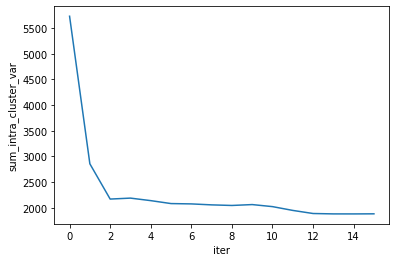

In [148]:
plot = sns.lineplot(data=df_sum_intra_clusters_variances, y='sum_intra_cluster_var', x='iter')

In [211]:
silhouette_score(Data_quant, df_optimal_clusters.sort_values(by='observations').cluster, metric='canberra')

0.3958985634914261

In [212]:
D_canberra = Matrix_Dist_Canberra(Data=Data_quant)

D_canberra = D_canberra + D_canberra.T

df_silhouette , mean_silhouette = silhouette(Distance_Matrix=D_canberra, k=4, df_clusters=df_optimal_clusters)

mean_silhouette

0.39752207743697565

### Prueba con Distancia Pearson

In [34]:
df_optimal_clusters, df_clusters_iter_list, sort_df_sum_intra_clusters_variances, df_sum_intra_clusters_variances = k_means(k=4, Data=Data_quant, d='Pearson', var=np.var(Data_quant), random_seed=123, n_iter=15)

In [151]:
df_optimal_clusters

,observations,cluster
0,382,3.0
1,732,2.0
2,1888,2.0
3,679,2.0
4,1004,2.0
...,...,...
1900,1122,2.0
1901,1346,2.0
1902,1406,1.0
1903,1389,0.0


In [153]:
df_clusters_iter_list[0:3]

[      observations  cluster
 0              382      3.0
 1              732      2.0
 2             1888      3.0
 3              679      2.0
 4             1004      3.0
 ...            ...      ...
 1900          1122      2.0
 1901          1346      3.0
 1902          1406      1.0
 1903          1389      0.0
 1904          1534      0.0
 
 [1905 rows x 2 columns],
       observations  cluster
 0              382      3.0
 1              732      2.0
 2             1888      3.0
 3              679      2.0
 4             1004      3.0
 ...            ...      ...
 1900          1122      2.0
 1901          1346      3.0
 1902          1406      1.0
 1903          1389      0.0
 1904          1534      3.0
 
 [1905 rows x 2 columns],
       observations  cluster
 0              382      3.0
 1              732      2.0
 2             1888      2.0
 3              679      2.0
 4             1004      3.0
 ...            ...      ...
 1900          1122      2.0
 1901          1

In [155]:
sort_df_sum_intra_clusters_variances.head(4)

,sum_intra_cluster_var,iter
4,10957.072584,4
5,10994.965556,5
3,11132.851402,3
6,11225.767564,6


In [156]:
df_sum_intra_clusters_variances.head(4)

,sum_intra_cluster_var,iter
0,28596.572339,0
1,14726.663383,1
2,11718.809584,2
3,11132.851402,3


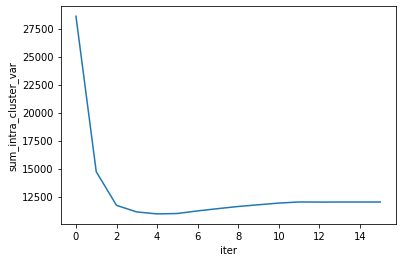

In [157]:
plot = sns.lineplot(data=df_sum_intra_clusters_variances, y='sum_intra_cluster_var', x='iter')

In [207]:
# silhouette_score(Data_quant, df_optimal_clusters.sort_values(by='observations').cluster, metric='pearson') # No esta definida Pearson

In [208]:
D_pearson = Matrix_Dist_Mahalanobis(Data=Data_quant)

D_pearson = D_pearson + D_pearson.T

df_silhouette , mean_silhouette = silhouette(Distance_Matrix=D_pearson, k=4, df_clusters=df_optimal_clusters)

mean_silhouette

0.24009689010286675

### Prueba Distancia Mahalanobis

In [198]:
S_inv = np.linalg.inv( np.cov(Data_quant , rowvar=False) )

In [199]:
df_optimal_clusters, df_clusters_iter_list, sort_df_sum_intra_clusters_variances, df_sum_intra_clusters_variances = k_means(k=4, Data=Data_quant, d='Mahalanobis', S_inv=S_inv, random_seed=123, n_iter=25)

In [200]:
df_optimal_clusters

,observations,cluster
0,382,3.0
1,732,2.0
2,1888,1.0
3,679,2.0
4,1004,1.0
...,...,...
1900,1122,2.0
1901,1346,1.0
1902,1406,2.0
1903,1389,0.0


In [184]:
df_clusters_iter_list[0:3]

[      observation  cluster
 0             382        0
 1             732        0
 2            1888        0
 3             679        0
 4            1004        0
 ...           ...      ...
 1900         1122        3
 1901         1346        3
 1902         1406        3
 1903         1389        3
 1904         1534        3
 
 [1905 rows x 2 columns],
       observations  cluster
 0              382      3.0
 1              732      2.0
 2             1888      3.0
 3              679      0.0
 4             1004      0.0
 ...            ...      ...
 1900          1122      0.0
 1901          1346      3.0
 1902          1406      2.0
 1903          1389      1.0
 1904          1534      0.0
 
 [1905 rows x 2 columns],
       observations  cluster
 0              382      3.0
 1              732      2.0
 2             1888      3.0
 3              679      0.0
 4             1004      0.0
 ...            ...      ...
 1900          1122      0.0
 1901          1346      1.0

In [185]:
sort_df_sum_intra_clusters_variances.head(4)

,sum_intra_cluster_var,iter
15,18118.627584,15
14,18299.629315,14
16,18350.722615,16
17,18660.002058,17


In [186]:
df_sum_intra_clusters_variances.head(4)

,sum_intra_cluster_var,iter
0,28206.445903,0
1,22921.160154,1
2,22356.872434,2
3,21975.798271,3


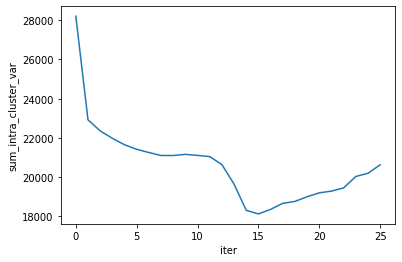

In [187]:
plot = sns.lineplot(data=df_sum_intra_clusters_variances, y='sum_intra_cluster_var', x='iter')

In [201]:
silhouette_score(Data_quant, df_optimal_clusters.sort_values(by='observations').cluster, metric='mahalanobis')

0.23882324114312004

In [202]:
D_maha = Matrix_Dist_Mahalanobis(Data=Data_quant)

D_maha = D_maha + D_maha.T

df_silhouette , mean_silhouette = silhouette(Distance_Matrix=D_maha, k=4, df_clusters=df_optimal_clusters)

mean_silhouette

## K-means with `sklearn` 

### by defect it uses Euclidean distance, and there aren't another options

In [188]:
from sklearn.cluster import KMeans

In [206]:
kmeans_init = KMeans(n_clusters=4, init='random', n_init=15, max_iter=200, random_state=123)

In [207]:
kmeans_init.fit(Data_quant)

KMeans(init='random', max_iter=200, n_clusters=4, n_init=15, random_state=123)

In [208]:
kmeans_init.cluster_centers_ # centroids

array([[2.51423060e+01, 5.52044213e+01, 2.00370258e+07, 4.97230518e+02,
        3.64705882e+00, 4.61764706e+00],
       [2.51663735e+01, 5.52243697e+01, 7.51525617e+06, 2.80158637e+02,
        3.43396226e+00, 4.26415094e+00],
       [2.51428118e+01, 5.52113290e+01, 2.94216875e+06, 1.75164955e+02,
        2.45196507e+00, 3.22052402e+00],
       [2.51051038e+01, 5.52124073e+01, 1.13707733e+06, 1.02066241e+02,
        1.46102941e+00, 2.15367647e+00]])

In [209]:
kmeans_init.labels_

array([2, 2, 3, ..., 2, 3, 3])

In [210]:
df_optimal_clusters = pd.DataFrame({'observations': range(0,len(Data_quant)), 'cluster': kmeans_init.labels_})

In [211]:
df_optimal_clusters

,observations,cluster
0,0,2
1,1,2
2,2,3
3,3,2
4,4,3
...,...,...
1900,1900,3
1901,1901,3
1902,1902,2
1903,1903,3


In [212]:
silhouette_score(Data_quant, kmeans_init.labels_, metric='euclidean')

0.6196456411116558

### K-means++  

In [230]:
kmeans_init = KMeans(n_clusters=4, init='k-means++', n_init=15, max_iter=200, random_state=123)

In [226]:
kmeans_init.fit(Data_quant)

KMeans(max_iter=200, n_clusters=4, n_init=15, random_state=123)

In [227]:
silhouette_score(Data_quant, kmeans_init.labels_, metric='euclidean')

0.6724058746599259

## K-Hyperparameter-tunnig for K-means `sklearn`

### Usando Silhouette

In [233]:
silhouette_avg = []
search_space = range(2,30)

for k in search_space :

    kmeans_init = KMeans(n_clusters=k, init='k-means++', n_init=15, max_iter=200, random_state=123)
    
    kmeans_init.fit(Data_quant)

    silhouette_avg.append( silhouette_score(Data_quant, kmeans_init.labels_) )

df_k_silhouette = pd.DataFrame({'k': search_space, 'silhouette_avg': silhouette_avg})

In [235]:
df_k_silhouette.head(4)

,k,silhouette_avg
0,2,0.914858
1,3,0.683691
2,4,0.672406
3,5,0.614485


In [238]:
df_k_silhouette_sort = df_k_silhouette.sort_values(by='silhouette_avg', ascending=False)

df_k_silhouette_sort.head(4)

,k,silhouette_avg
0,2,0.914858
1,3,0.683691
2,4,0.672406
3,5,0.614485


In [240]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

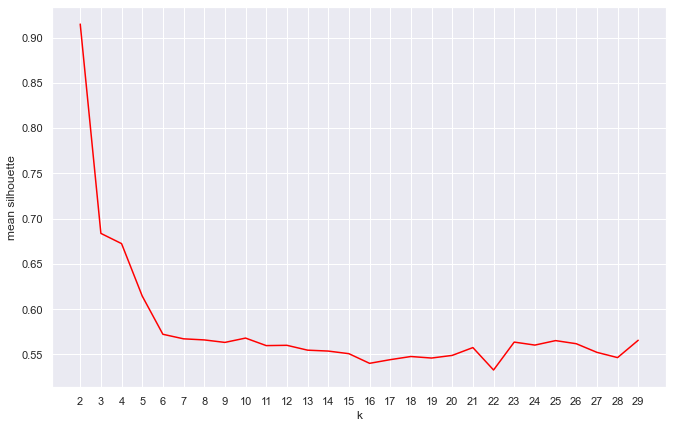

In [248]:
fig = plt.figure(figsize=(11,7))

p=sns.lineplot(x=search_space, y=silhouette_avg , color='red')

plt.ylabel("mean silhouette")
plt.xlabel("k")

p.set_xticks( search_space )

# fig.savefig('p2.png', format='png', dpi=1200)

plt.show()

### Usando la suma de varianzas intra-clusters

`inertia_` es la suma de las varianzas intra-cluster de todos los clusters.

In [250]:
sum_variance_intra_clusters = []

for k in search_space:

    kmeans_init = KMeans(n_clusters=k, init='k-means++', n_init=15, max_iter=200, random_state=123)
    
    kmeans_init.fit(Data_quant)

    sum_variance_intra_clusters.append( kmeans_init.inertia_) 

df_k_sum_variance_intra_clusters = pd.DataFrame({'k': search_space, 'sum_variance_intra_clusters': sum_variance_intra_clusters})

In [ ]:
df_k_sum_variance_intra_clusters_sort = df_k_sum_variance_intra_clusters.sort_values(by='sum_variance_intra_clusters', ascending=True)

df_k_sum_variance_intra_clusters_sort.head(4)

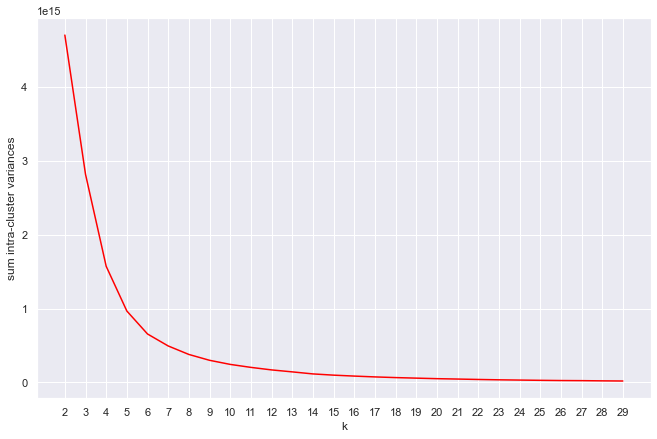

In [251]:
fig = plt.figure(figsize=(11,7))

p=sns.lineplot(x=search_space, y=sum_variance_intra_clusters , color='red')

plt.ylabel("sum intra-cluster variances")
plt.xlabel("k")

p.set_xticks( search_space )

# fig.savefig('p2.png', format='png', dpi=1200)

plt.show()

## Shiloutte programado en `Python`

In [203]:
def silhouette(Distance_Matrix , k, df_clusters):

    # Distance_Matrix tiene que ser una matriz de distancias calculada sobre un Data-set.
    # Se tiene que haber aplicado un algoirtmo de clustering como k-medias o k-medoids sobre un Data-set --> k , df_clusters
    # df_clusters debe ser un pd.DataFrame obtenido tras aplicar un algoritmo de clustering como k-medoisds sobre el Data-set.
    # Deberá tener al menos dos columnas: 
    # 'observaciones' (indices de las observaciones de Data) y 'cluster' (indice del cluster al que pertenece cada observacion).

    def f(i,h):

        f_i_h_list = []
        C_h = df_clusters.loc[df_clusters.cluster == h , :]

        for r in np.array(C_h.observations) :

            f_i_h_list.append( Distance_Matrix[i , r] )

        f_i_h = sum(f_i_h_list) / (len(C_h)-1)  # distancia media entre x_i y el cluster C_h

        return f_i_h
    
    def b(i):

        for h in range(0,k):

            C_h = df_clusters.loc[df_clusters.cluster == h , :]

            if i in np.array(C_h.observations) :

                b_i = f(i,h)
    
        return b_i
   
    def a(i):

        a_i_list = []

        for h in range(0,k):

            C_h = df_clusters.loc[df_clusters.cluster == h , :]

            if i in np.array(C_h.observations) :

                for j in range(0,k):

                    if j != h :

                        a_i_list.append( f(i,j) )

                a_i = min(a_i_list)
    
        return a_i

    def silhouette_compute(i) :

        s_i = (a(i) - b(i)) / max( [a(i) , b(i)] )

        return s_i
  
    s_i_list = []

    for i in np.array(df_clusters.observations) :

        s_i_list.append(silhouette_compute(i))
   
    mean_silhouette =  sum(s_i_list) / len(s_i_list)  

    df_silhouette = pd.DataFrame({'silhouette':s_i_list , 'observations':df_clusters.observations , 'cluster':df_clusters.cluster})

    return df_silhouette , mean_silhouette


In [120]:
df_optimal_clusters, df_clusters_iter_list, sort_df_sum_intra_clusters_variances, df_sum_intra_clusters_variances = k_means(k=4, Data=Data_quant, d='Euclidea', random_seed=123, n_iter=15)

In [192]:
D_euclidean = Matrix_Dist_Euclidea(Data=Data_quant)

D_euclidean = D_euclidean + D_euclidean.T

df_silhouette , mean_silhouette = silhouette(Distance_Matrix=D_euclidean, k=4, df_clusters=df_optimal_clusters)

In [193]:
mean_silhouette

0.5555770916912831

In [ ]:
df_silhouette

In [194]:
silhouette_score(X=Data_quant, metric='euclidean', labels=df_optimal_clusters.sort_values(by='observations').cluster)

0.5548752565475771

## K-Medoids programmed in `Python`

In [235]:
def k_medoids(k, Data, d, random_seed=123, n_iter=50, q=None, var=None, S_inv=None):

    # Data --> a numpy array
    # d --> name of distance (Euclidea, Minkowski, Canberra, Pearson or Mahalanobis)
    # q --> parametro necesario si se usa la distancia Minkowski
    # S_inv --> parametro necesario si se usa la distancia Mahalanobis
    # random_seed --> semilla aleatoria
    # k --> nº clusters
    # n_iter --> nº maximo de iteraciones del algoritmo

###########################################################################################

    df_clusters_iter_list = []

    if isinstance(Data, pd.DataFrame):
        Data = Data.to_numpy()
    elif isinstance(Data, np.ndarray):
        pass

###########################################################################################

###########################################################################################

    # Distance definition:

    Dist_d = globals()["Dist_" + d]

    Matrix_Dist_d = globals()["Matrix_Dist_" + d]


    def Distance(x_i, x_r, d, q, var, S_inv):
        
        if d == "Euclidea":
    
            distance = Dist_d(x_i , x_r)

        elif d == "Canberra":
            
            distance = Dist_d(x_i , x_r)

        elif d == "Minkowski":
             
            distance = Dist_d(x_i , x_r, q)

        elif d == "Pearson":
    
            distance = Dist_d(x_i , x_r, variance=var)

        elif d == "Mahalanobis":
         
            distance = Dist_d(x_i-x_r, S_inv)

        return distance

    #####################################################

    def Distance_Matrix(Data, d, q=None):
        
        if d == "Euclidea":
    
            M = Matrix_Dist_Euclidea(Data)

        elif d == "Canberra":
            
            M = Matrix_Dist_Canberra(Data)

        elif d == "Minkowski":
             
            M = Matrix_Dist_Minkowski(Data, q)

        elif d == "Pearson":
    
            M = Matrix_Dist_Pearson(Data)

        elif d == "Mahalanobis":
         
            M = Matrix_Dist_Mahalanobis(Data)

        return M

###########################################################################################

# Se generan los clusters iniciales aleatoreamente

    # Random generation of the initial clusters:

    sample = resample(range(0, len(Data)), n_samples=len(Data), replace=False, random_state=random_seed)

    df_sample = pd.DataFrame({'index': range(0,len(Data)) , 'sample':sample})

    Q = []

    for q in np.arange(0 , 1 + 1/k , 1/k):

        Q.append( np.quantile( range(0, len(Data)) , q ).round(0) )

    labels_clusters = np.array([0])

    for j in range(0,k):
   
        labels_clusters = np.concatenate([labels_clusters, np.repeat( j, len( df_sample.loc[Q[j]:(math.floor(Q[j+1])-1), 'sample'] ) ) ] ) 

    df_cluster = pd.DataFrame({'observation': df_sample['sample'] , 'cluster': labels_clusters})

    df_clusters_iter_list.append(df_cluster)

###########################################################################################


# calculamos los medoids de los clusters iniciales

    D = Distance_Matrix(Data, d, q)

   ######################

    medoids = []
    label_medoids =[]

    for j in range(0, k):

      observations_index_cluster_j = df_cluster.loc[df_cluster.cluster == j, :].observation

      D_j = D[observations_index_cluster_j, :][: ,observations_index_cluster_j] # matriz distancias para el cluster j

      sum_distances = D_j.sum(axis=1) # suma de la matriz por filas

      # indice en la matriz de la observacion que minimiza la suma de distancias en el cluster j --> medoid del cluster j
      h = np.where( sum_distances == min( sum_distances ) ) 

      df_cluster_j = df_cluster.loc[df_cluster.cluster == j , ]    

      # df_cluster_j.iloc[h[0],:].observacion es el indice en el data set original de la observacion medoid del cluster j 


      if len(h[0]) == 1 :  # hay un solo medoid en el cluster j 
        
        medoids.append( Data[ df_cluster_j.iloc[h[0],:].observation , : ]  ) # su componente j es el medoid del cluster j

        label_medoids.append(df_cluster_j.iloc[h[0],:].observation)

      if len(h[0]) > 1 : # hay varios medoids en el cluster j 
        
        medoids.append( Data[ int(df_cluster_j.iloc[h[0][0],:].observation)  , : ]  ) # su componente j es el medoid del cluster j

        label_medoids.append( int(df_cluster_j.iloc[h[0][0],:].observation) )

      # Los condicionales son para evitar problemas en el caso de que en un cluster haya mas de un medoid.
      # Puede haber dos o mas observaciones que cumplan con la definicion de medoid, para alguno de los clusters.
      # Si un cluster tiene varios medoids, nos quedamos solo con uno.

###########################################################################################


   # Calculamos la suma de varianzas intra cluster para los clusters iniciales

   # Computing the sum of intra-clusters variances for the initial cluster:

    distances = [ ]

    intra_cluster_variance_list , sum_intra_clusters_variances, sum_intra_clusters_variances_list = [ ], [ ], [ ]

    for j in range(0,k):

        observations_index_cluster_j = df_cluster.loc[df_cluster.cluster == j, :].observation 

        for i in observations_index_cluster_j :

            distances.append(Distance(x_i=Data[i,:], x_r=medoids[j], d=d, q=q, var=var, S_inv=S_inv))

        # distances = Parallel(n_jobs=-1)(delayed(Distance)(x_i=Data[i,:], x_r=Centroids[j], d=d, q=q, var=var, S_inv=S_inv) for i in observations_index_cluster_j)          

        square_distances = [x**2 for x in distances]
        intra_cluster_variance = sum(square_distances)
        intra_cluster_variance_list.append( intra_cluster_variance )

    sum_intra_clusters_variances.append( sum(intra_cluster_variance_list) )
    sum_intra_clusters_variances_list.append( sum_intra_clusters_variances )

###########################################################################################

# Asignar cada observacion a su cluster más cercano 

    for b in range(0 , n_iter):
       
       # Assign each observation to their nearest cluster: 

        labels_clusters = []

        for i in df_sample['sample']:

            distances = []
    
            for j in range(0,k):

                distances.append( Distance(x_i=Data[i,:], x_r=medoids[j], d=d, q=q, var=var, S_inv=S_inv) )  

            df_distances_x_i_clusters = pd.DataFrame({'Distances' : distances , 'Cluster': range(0,k)})

            df_distances_x_i_clusters_sort = df_distances_x_i_clusters.sort_values(by='Distances', ascending=True)

            labels_clusters.append( df_distances_x_i_clusters_sort.iloc[0]['Cluster'] )
        
        df_cluster = pd.DataFrame({'observation' : df_sample['sample'] , 'cluster': labels_clusters})

###########################################################################################

       # Calculamos los medoids de los nuevos clusters

        medoids = []
        label_medoids =[]


        for j in range(0, k):                    
                
                observations_index_cluster_j = df_cluster.loc[df_cluster.cluster == j, :].observation

                D_j = D[observations_index_cluster_j, :][: ,observations_index_cluster_j] # matriz distancias para el cluster j

                sum_distances = D_j.sum(axis=1) # suma de la matriz por filas

                h = np.where( sum_distances == min( sum_distances) ) # indice en la matriz de la observacion que minimiza la suma de distancias en el cluster j --> medoid del cluster j

                df_cluster_j = df_cluster.loc[df_cluster.cluster == j , ]    

                # df_cluster_j.iloc[h[0],:].observacion  es el indice en el data set original de la observacion medoid del cluster j 
                
                if len(h[0]) == 1 : 
                    
                    medoids.append( Data[ df_cluster_j.iloc[h[0],:].observation , : ]  )   # su componente j es el medoid del cluster j

                    label_medoids.append(df_cluster_j.iloc[h[0],:].observation)


                elif len(h[0]) > 1 : 
                  
                    medoids.append( Data[ int(df_cluster_j.iloc[h[0][0], :].observation)  , : ]  ) # su componente j es el medoid del cluster j
                
                    label_medoids.append( int(df_cluster_j.iloc[h[0][0], :].observation) )
                
                # Los condicionales son para evitar problemas en el caso de que en un cluster haya mas de un medoid.
                # Puede haber dos o mas observaciones que cumplan con la definicion de medoid, para alguno de los clusters.
                # Si un cluster tiene varios medoids, nos quedamos solo con uno.

###########################################################################################

        # Calculamos la suma de varianzas intra cluster para los nuevos clusters

        distances = []
        intra_cluster_variance_list , sum_intra_clusters_variances = [ ], [ ]

        for j in range(0,k):

            observations_index_cluster_j = df_cluster.loc[df_cluster.cluster == j, :].observation 

            for i in observations_index_cluster_j :

                distances.append( Distance(x_i=Data[i,:], x_r=medoids[j], d=d, q=q, var=var, S_inv=S_inv) )

            # distances = Parallel(n_jobs=-1)(delayed(Distance)(x_i=Data[i,:], x_r=Centroids[j], d=d, q=q, var=var, S_inv=S_inv) for i in observations_index_cluster_j)          

            square_distances = [x**2 for x in distances]
            intra_cluster_variance = sum(square_distances)
            intra_cluster_variance_list.append( intra_cluster_variance )

        sum_intra_clusters_variances.append( sum(intra_cluster_variance_list) )
        sum_intra_clusters_variances_list.append( sum_intra_clusters_variances )


######################################################################################

        df_clusters_iter = pd.DataFrame({'observations': df_sample['sample']  , 'cluster': labels_clusters })

        df_clusters_iter_list.append(df_clusters_iter)

######################################################################################
######################################################################################
    
    # unlist a list:

    sum_intra_clusters_variances_list = list(chain.from_iterable(sum_intra_clusters_variances_list))

######################################################################################
    df_sum_intra_clusters_variances = pd.DataFrame({'sum_intra_cluster_var':sum_intra_clusters_variances_list  , 'iter': range(0, n_iter+1)})
    
    sort_df_sum_intra_clusters_variances = df_sum_intra_clusters_variances.sort_values(by='sum_intra_cluster_var', ascending=True)

    optimal_iter = sort_df_sum_intra_clusters_variances.iloc[0,1]

    df_optimal_clusters = df_clusters_iter_list[optimal_iter]
######################################################################################

    return df_optimal_clusters, df_clusters_iter_list, sort_df_sum_intra_clusters_variances,  df_sum_intra_clusters_variances

### Trying with Euclidean distance

In [236]:
df_optimal_clusters, df_clusters_iter_list, sort_df_sum_intra_clusters_variances,  df_sum_intra_clusters_variances = k_medoids(k=4, Data=Data_quant, d='Euclidea', random_seed=123, n_iter=15, q=None, var=None, S_inv=None)


In [237]:
df_optimal_clusters

,observations,cluster
0,382,1.0
1,732,2.0
2,1888,2.0
3,679,3.0
4,1004,1.0
...,...,...
1900,1122,3.0
1901,1346,2.0
1902,1406,0.0
1903,1389,2.0


In [239]:
df_clusters_iter_list[0:2]

[      observation  cluster
 0             382        0
 1             732        0
 2            1888        0
 3             679        0
 4            1004        0
 ...           ...      ...
 1900         1122        3
 1901         1346        3
 1902         1406        3
 1903         1389        3
 1904         1534        3
 
 [1905 rows x 2 columns],
       observations  cluster
 0              382      1.0
 1              732      2.0
 2             1888      2.0
 3              679      3.0
 4             1004      1.0
 ...            ...      ...
 1900          1122      3.0
 1901          1346      2.0
 1902          1406      0.0
 1903          1389      2.0
 1904          1534      1.0
 
 [1905 rows x 2 columns]]

In [241]:
sort_df_sum_intra_clusters_variances.head(4)

,sum_intra_cluster_var,iter
1,3.892252e+16,1
2,3.894018e+16,2
3,3.894018e+16,3
4,3.894018e+16,4


In [242]:
df_sum_intra_clusters_variances.head(4)

,sum_intra_cluster_var,iter
0,4.985438e+16,0
1,3.892252e+16,1
2,3.894018e+16,2
3,3.894018e+16,3


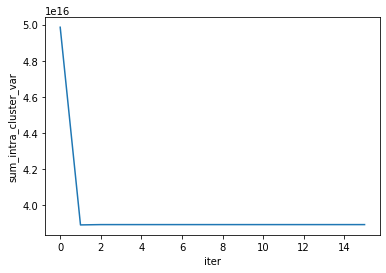

In [243]:
plot = sns.lineplot(data=df_sum_intra_clusters_variances, y='sum_intra_cluster_var', x='iter')

In [244]:
silhouette_score(Data_quant, df_optimal_clusters.sort_values(by='observations').cluster, metric='euclidean')

0.30222108351014065

In [245]:
D_euclidean = Matrix_Dist_Euclidea(Data=Data_quant)

D_euclidean = D_euclidean + D_euclidean.T

df_silhouette , mean_silhouette = silhouette(Distance_Matrix=D_euclidean, k=4, df_clusters=df_optimal_clusters)

mean_silhouette

0.30363671865033204

**PROBAR CON MAS DISTANCIAS. RECORDAR QUE AHORA SE PUEDEN UAR DATOS DE TIPO MIXTO (y con ello distancias tipo mixto)**

### K-Medoids con libreria `Kmedoids`

In [246]:
import kmedoids

In [ ]:
D_euclidean = Matrix_Dist_Euclidea(Data=Data_quant)

D_euclidean = D_euclidean + D_euclidean.T

In [264]:
k_medoids_init = kmedoids.fastermsc(diss=D_euclidean , medoids=4 , max_iter=100, init='random', random_state=123)

In [265]:
k_medoids_init.labels

array([2, 2, 3, ..., 2, 3, 3], dtype=uint64)

In [266]:
k_medoids_init.medoids

array([382,   6,   5,   2], dtype=uint64)

In [267]:
df_clusters =  pd.DataFrame( {'observations': range(0,len(Data)) ,  'cluster': k_medoids_init.labels} )
df_clusters

,observations,cluster
0,0,2
1,1,2
2,2,3
3,3,2
4,4,3
...,...,...
1900,1900,3
1901,1901,3
1902,1902,2
1903,1903,3


In [268]:
df_silhouette , mean_silhouette = silhouette(Distance_Matrix=D_euclidean, k=4, df_clusters=df_clusters)

In [269]:
mean_silhouette

0.6338676522914983